In [649]:
import pandas as pd
import numpy as np
import re, os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
jet = plt.get_cmap('jet')


import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.regression.linear_model import WLS
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.discrete.discrete_model import Probit
from statsmodels.regression.quantile_regression import QuantReg
from scipy.stats import norm
import seaborn as sns
from scipy.stats import chisquare
from statsmodels.discrete.discrete_model import Poisson

import itertools
data_path = "C:/Users/SpiffyApple/Documents/USC/OwnResearch/proposal"

In [3]:
#convenience function
def toLatex(tmpDF, file_name, regOut = False):
    if regOut == False:
        with open("/".join([data_path,'output',file_name]), 'w+') as f:
            f.write(tmpDF.to_latex())
    if regOut:
        with open("/".join([data_path,'output',file_name]), 'w+') as f:
            f.write(tmpDF.as_latex())
    return(tmpDF)

def toExcel(tmpDF, file_name):
    tmpDF.to_excel("/".join([data_path,'output',file_name]))
    return(tmpDF)

# AHS Data

The data come from [here](https://www.census.gov/programs-surveys/ahs/data/2015/ahs-2015-public-use-file--puf-/2015-ahs-metropolitan-puf-microdata.html). Important AHS data documentation [here](https://www.census.gov/content/dam/Census/programs-surveys/ahs/tech-documentation/2015/Getting%20Started%20with%20the%20AHS%20PUF.pdf), variable [labels](https://www.census.gov/data-tools/demo/codebook/ahs/ahsdict.html?s_appName=ahsdict&s_year=2015)

Other years include:, [2017]()
[2013](https://www.census.gov/programs-surveys/ahs/data/2013/ahs-2013-public-use-file--puf-/ahs-2013-national-public-use-file--puf-.html), and 
[2011](https://www.census.gov/programs-surveys/ahs/data/2011/ahs-national-and-metropolitan-puf-microdata.html)

Another useful link is the [QuickFacts](https://www.census.gov/quickfacts/fact/table/milwaukeecitywisconsin/PST045217) for Milwaukee which gives basic information on housing and demographics

**Data are prepped in the AHS data 2015 preparation** notebook. The results are uploaded here for expediency

In [310]:
## load prepped data
df = pd.read_csv("/".join([data_path, 'AHS2015prepped_ver2.csv']),low_memory=False)

In [311]:
## labels for columns
ahsdict = pd.read_csv("/".join([data_path, 'AHSDICT_28AUG18_23_35_13_43_S.csv']))
#drop unnecessary columns
ahsdict.drop(['Disclosure','Variable_Number','INUNIVERSE','Topic_Number','Present_in_Survey_Years','Topic_Subtopic_ID','Imputation_Strategy','Question','Instrument_Variable_Name','Survey Year','Subtopic'],axis=1,inplace=True)
ahsdict.set_index('Variable',inplace=True)

In [312]:
## create a convenience function for variable look up
def varlu(s):
    return(ahsdict[ahsdict.Description.str.lower().str.contains(s)])

In [ ]:
## simpify race
df.loc[df.HHRACE.str.contains("Alaska"),'HHRACE'] = 'indigenous'

In [493]:
Milwaukee = df.loc[df.cbsatitle.str.contains('Milwaukee') & (df.renter==1)].copy()

In [494]:
Milwaukee.shape

(915, 308)

# Is housing inadequacy racist?

In [403]:
low, high = Milwaukee.RENT.quantile([.025,.975])

In [505]:
Milwaukee.loc[:,'rentPerRoom'] = Milwaukee.RENT/Milwaukee.TOTROOMS

In [544]:
Milwaukee = Milwaukee.loc[~Milwaukee.HHRACE.str.contains("WhiteAsian|WhiteBlack")]
Milwaukee.shape

(908, 309)

Text(0, 0.5, 'density')

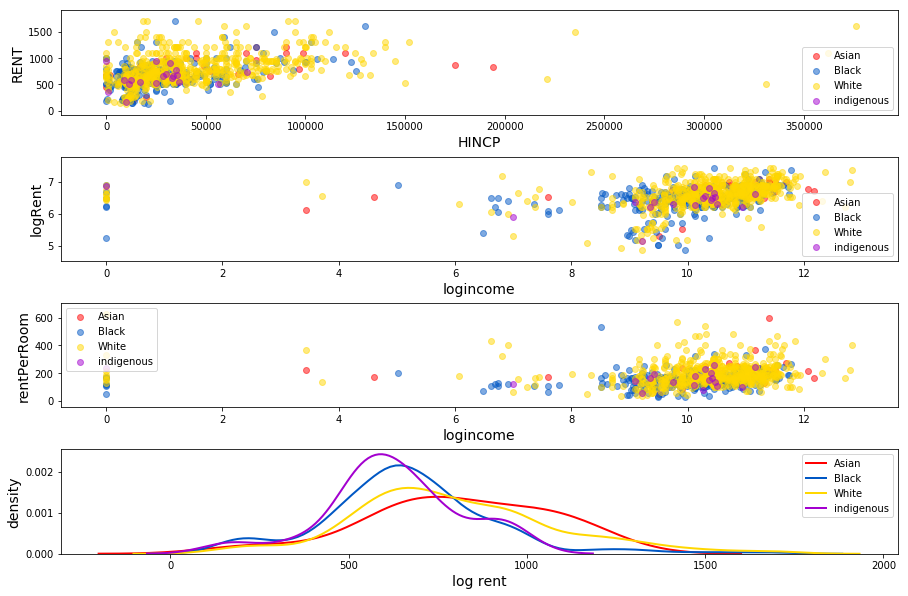

In [506]:
fig, axes = plt.subplots(4,1)
y_set=['RENT','logRent','rentPerRoom']
x_set=['HINCP','logincome','logincome']

for ax, y, x in zip(axes.flatten(), y_set, x_set):
    palette = iter(plt.cm.prism(np.linspace(0,1,5)))
    for name, group in Milwaukee.loc[(Milwaukee.RENT>low) & (Milwaukee.RENT<high)].groupby('HHRACE'):
        
        if group.RENT.shape[0]>10:
            ax.scatter(y = group[y], x=group[x], label=name, alpha=.5, color=next(palette))
            ax.legend()
            ax.set_ylabel(y,fontsize=14)
            ax.set_xlabel(x,fontsize =14)
            
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.4)
fig.set_figwidth(15)
fig.set_figheight(10)

palette = iter(plt.cm.prism(np.linspace(0,1,5)))

for name, group in Milwaukee.loc[(Milwaukee.RENT>low) & (Milwaukee.RENT<high)].groupby('HHRACE'):
    if group.RENT.shape[0]>10:
        sns.kdeplot(group['RENT'],label=name, color=next(palette), kernel='gau', bw='scott', linewidth=2, ax=axes[3])
        
axes[3].set_xlabel("log rent", fontsize=14)
axes[3].set_ylabel('density', fontsize=14)

Text(0, 0.5, 'share')

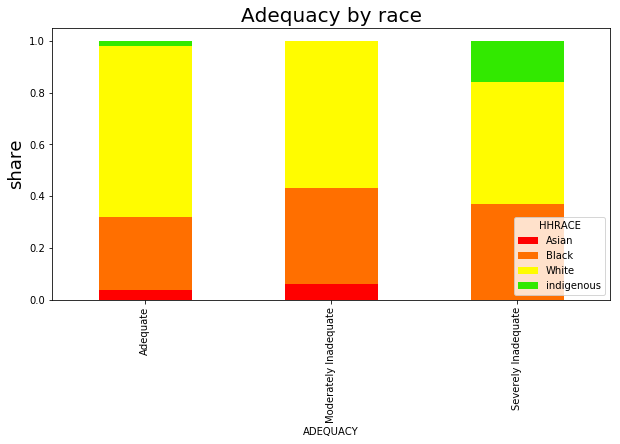

In [545]:
adequacyByRace = Milwaukee[['ADEQUACY','HHRACE', 'RENT']].groupby(["HHRACE",'ADEQUACY']).count().unstack()
palette = iter(plt.cm.prism(np.linspace(0,1,10)))

tmp = adequacyByRace.loc[:,'RENT']


(tmp/tmp.sum()).transpose().plot(kind='bar',stacked=True,color=palette, figsize=(10,5))
plt.title("Adequacy by race", fontsize=20)
plt.ylabel("share", fontsize=18)

In [546]:
(tmp/tmp.sum()).round(3)

ADEQUACY,Adequate,Moderately Inadequate,Severely Inadequate
HHRACE,,,
Asian,0.036,0.060,NaN
Black,0.284,0.373,0.368
White,0.660,0.566,0.474
indigenous,0.020,NaN,0.158


In [547]:
tmp = Milwaukee.groupby("HHRACE").RENT.count()
(tmp/tmp.sum()).round(2)

HHRACE
Asian         0.04
Black         0.29
White         0.65
indigenous    0.02
Name: RENT, dtype: float64

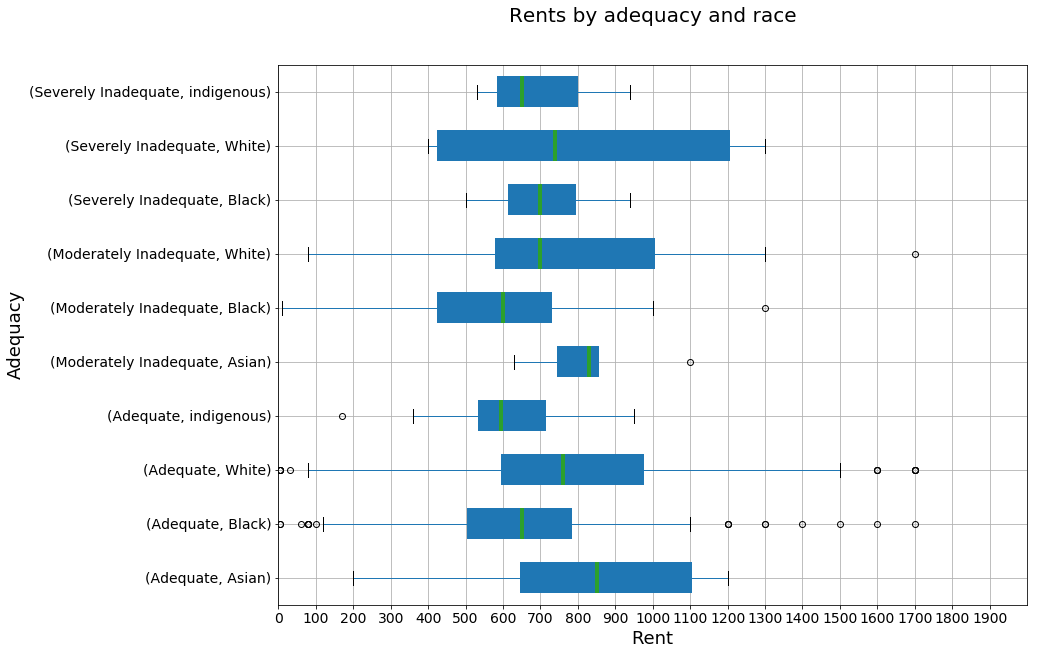

In [812]:
boxprops = dict(linestyle='-', linewidth=4)
medianprops = dict(linestyle='-', linewidth=4)

bplot =Milwaukee.boxplot('RENT',by=['ADEQUACY','HHRACE'], rot=0,figsize=(13,10), fontsize=14,boxprops=boxprops, medianprops=medianprops, vert=False, patch_artist=True)
plt.suptitle("Rents by adequacy and race", fontsize=20)
plt.ylabel("Adequacy",fontsize=18)
plt.xlabel("Rent", fontsize=18)
plt.xlim((0,2000))
plt.xticks(np.arange(0,2000,100))
_=plt.title('')

In [807]:
bplot.set_facecolor('red')

## Comparison Across Cities

In [737]:
diffDict = {}
pvalDict= {}
for cbsa in df.cbsatitle.unique():
    #print(cbsa)
    tmp=df.loc[(df.cbsatitle == cbsa) & (df.renter==1)].groupby("HHRACE").RENT.count()
    # get share of pop by race
    raceShare = tmp/tmp.sum()
    
    # get inadequacy done by race
    tmp = df.loc[(df.cbsatitle == cbsa) & (df.renter==1)][['ADEQUACY','HHRACE', 'RENT']].groupby(["HHRACE",'ADEQUACY']).count().unstack()
    adequacyByRace = (tmp).RENT
    adequacyByRaceShares = tmp/tmp.sum()
    
    diffs = (np.array(raceShare).reshape((adequacyByRace.shape[0],1)) - np.array(adequacyByRaceShares))
    diffDict[cbsa] = pd.DataFrame(-diffs, index=raceShare.index, columns = adequacyByRace.columns)
   
    #perform chi-squared test
    #expected = np.array(raceShare)[:,np.newaxis]*np.array(adequacyByRace.sum())
    #expected = pd.DataFrame(expected, columns=adequacyByRace.columns, index = adequacyByRace.index)
    #pvals = chisquare(expected.loc[['White','Black','Asian']], adequacyByRace.loc[['White','Black','Asian']], axis=0)[1].round(3)
    #pvalDict[cbsa] = pd.DataFrame(pvals, index = adequacyByRace.columns)

In [765]:
cbsaDiffs = pd.concat(diffDict).swaplevel().loc[['White','Asian','Black']].swaplevel()

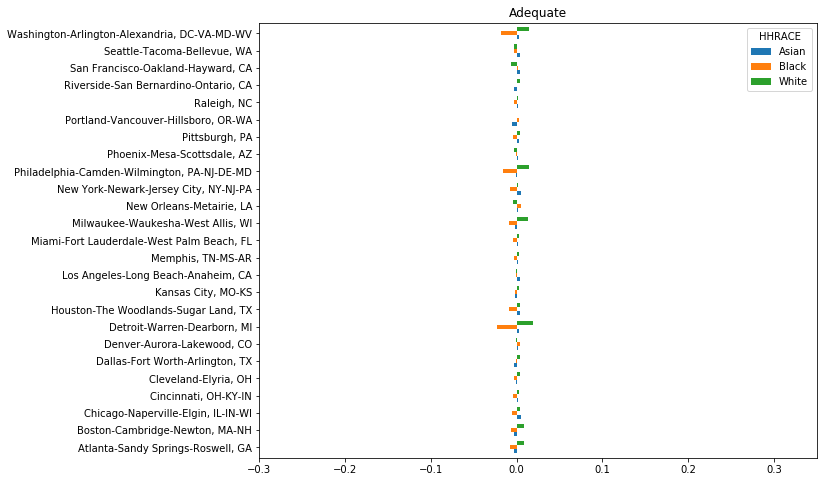

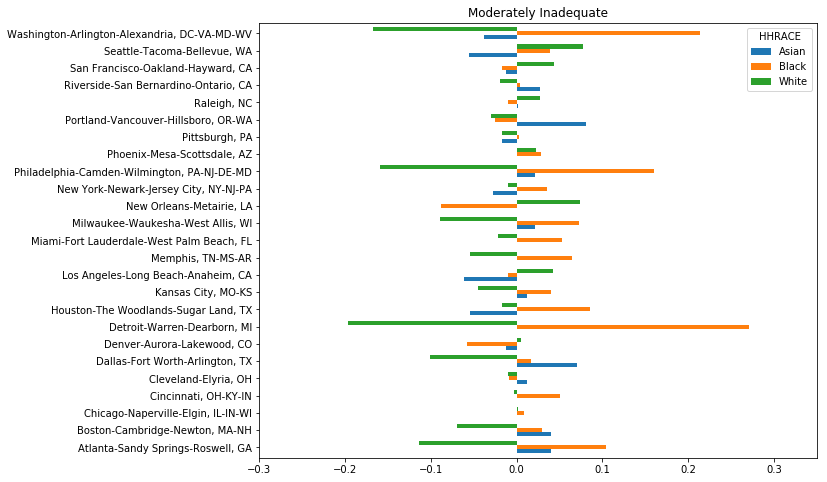

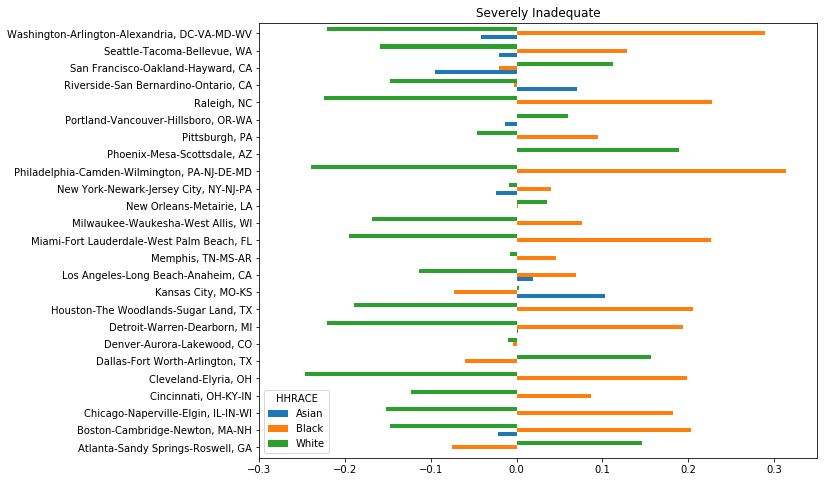

In [793]:
#fig,axes = plt.subplots(3, sharex=True)
for col in ['Adequate','Moderately Inadequate','Severely Inadequate']:
    cbsaDiffs[col].unstack(level=1).plot(kind='barh',title=col,width=.7,figsize=(10,8))
    plt.xlim(-.3,.35)
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.4)
#fig.set_figwidth(20)
#fig.set_figheight(25)
#plt.tight_layout()